# 09.02 Scaling and Ensembles

Data does not always come in a way our machine learning algorithms expects it.
We saw that concept a handful of times already:
we extracted extra features (e.g. polynomial features),
we did dimensionality reduction,
we used manifold techniques.
Yet, all these things may still fail against certain data.

![Wine](sl-wine.svg)

<div style="text-align:right;"><sup>sl-wine.svg</sup></div>

Note: This section is very dependent on the values produced by the random number generator.
You may want to run each piece of code several times.

For a start we import the usual stuff.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

And then the wine dataset,
which is an example of data that would fail a simple dimensionality reduction.

In [2]:
from sklearn.datasets import load_wine
wine = load_wine()
print(wine['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

One should explore the data first.
We will simply plot as many dimensions as we can at once.

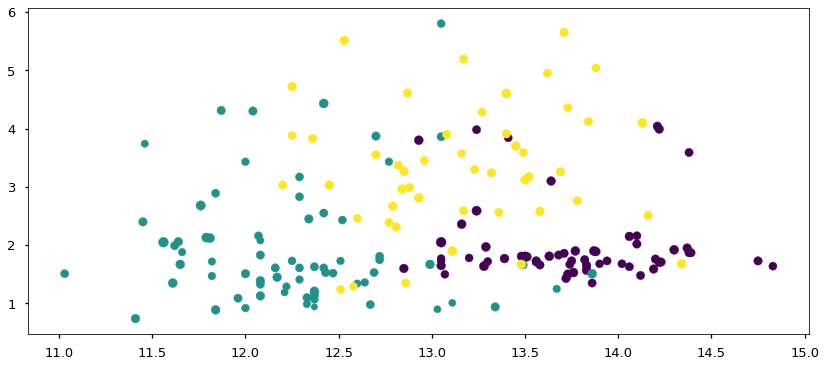

In [3]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(wine.data[:, 0], wine.data[:, 1], s=30*wine.data[:, 2], c=wine.target, cmap='viridis');

The classes seem to be difficult to separate.
Yet, we have just a few dimensions and a handful of samples,
therefore we can perform a full PCA and see whether we can project this data into a different space.

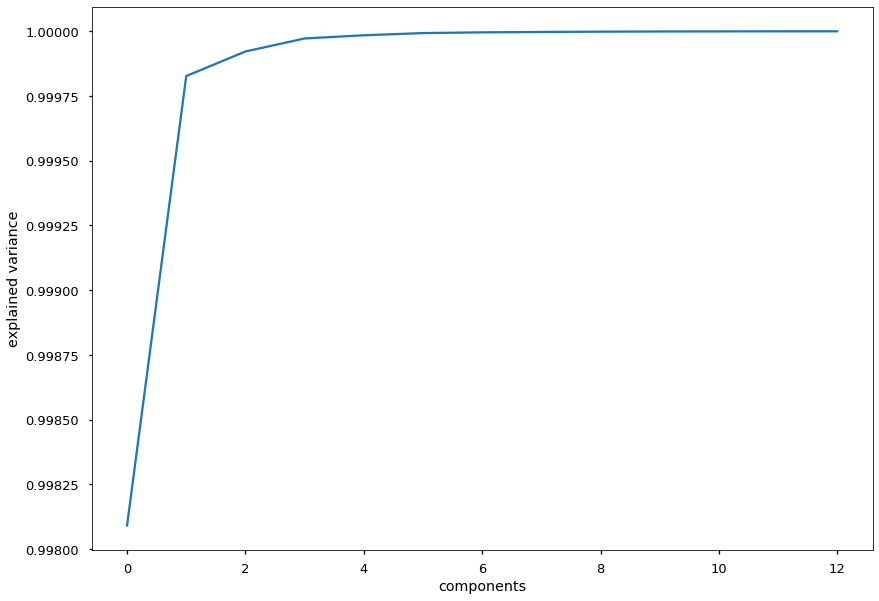

In [4]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(wine.data)
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set(xlabel='components', ylabel='explained variance');

Oh wow, two dimensional space seem to explain the data variance well enough.
And, since we can visualize a two dimensional space easily, we should do it.

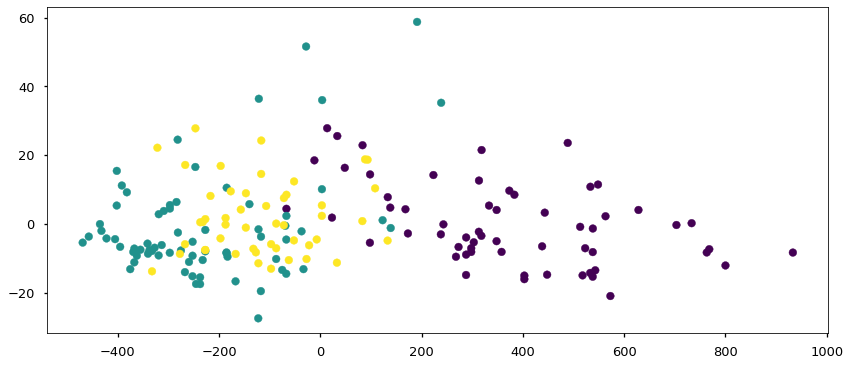

In [5]:
pca = PCA(n_components=2)
wine_pca = pca.fit_transform(wine.data)
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(wine_pca[:, 0], wine_pca[:, 1], s=60, c=wine.target, cmap='viridis');

Despite the fact that we did dimensionality reduction the data does not look separable.
Let's try something different, let's describe this data using `pandas`:

In [6]:
df = pd.DataFrame(wine.data, columns=[wine.feature_names])
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


The values of *magnesium* and *proline* have completely different magnitudes from all other features.
These features have much bigger values than all the others,
and since PCA will evaluate variance based on the values alone,
it will take these two features as the main variance explanation.
In other words, instead of finding the main variance in the data PCA is simply finding these two features.
Let's scale those things down and then apply PCA.

The `StandardScaler` centers the mean of every feature to zero,
and ensures that the variance of each feature is exactly one.

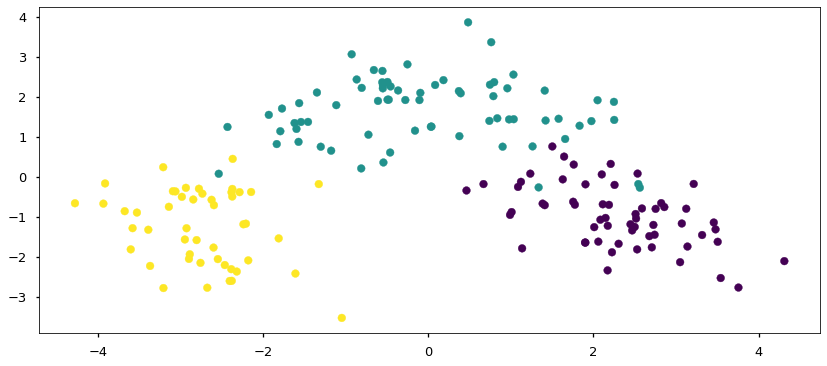

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
preprocess = make_pipeline(StandardScaler(), PCA(n_components=2))
wine_pca = preprocess.fit_transform(wine.data)
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(wine_pca[:, 0], wine_pca[:, 1], s=60, c=wine.target, cmap='viridis');

Now this is rather easy to separate.
And moreover, we probably do not need a complex classifier for it.

## Decision Trees

A decision tree is a rather simple classifier (or regressor).
During training a decision tree learns rules that divide
the feature space perpendicular to a feature.
In other words, at each training step,
the tree divides one dimension into two groups.

At the first training step the tree divides the entire feature space.
On all following steps the tree attempt to divide each resulting divided branch further.
This happens until all leaves contain only data with the same label,
or a stopping criteria is reached.

There are several algorithms to train a decision tree.
The algorithms are concerned in how, at each step, perform the best split.
At each step a tree can split the feature space into two separate areas using any of the features.
Therefore each feature is evaluated for the best split so that as many labels are separated,
then an information gain measure is used to decide which split produces the tree that better
slits classes apart.
The information gain measure differs between algorithms, most often we:

Take the split which minimizes the *gini* impurity:

$$
\sum_k \left[ \frac{\sum_i I(y_i = k)}{N} \left( 1 - \frac{\sum_i I(y_i = k)}{N} \right) \right]
$$

or, take the split which minimizes *cross-entropy*

$$
\sum_k \left[ - \frac{\sum_i I(y_i = k)}{N} log \left( \frac{\sum_i I(y_i = k)}{N} \right) \right]
$$

or even the split which minimizes the maximum misclassification error

$$
\sum_k \left[ 1 - max \left( \frac{\sum_i I(y_i = k)}{N} \right) \right]
$$

Where $k$ is each class and $N$ the number of samples being split.

No matter the split method the algorithm is always a greedy algorithm.
The tree will always attempt the split that will reduce the impurity the most *at the current step*.
By no means this guarantees that the final tree will be optimal,
or have the minimum overall impurity.

The stopping criteria are ways of making the tree not overfit the data.
We can define when leaves are too small to split or an overall maximum number of splits.
Without any criteria we will just split the data as much as we can.

In [8]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(wine_pca, wine.target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

As most `sklearn` classes the decision tree classifier has some sensible defaults.
We can look at how to classified the (dimensionality) reduces wine dataset.

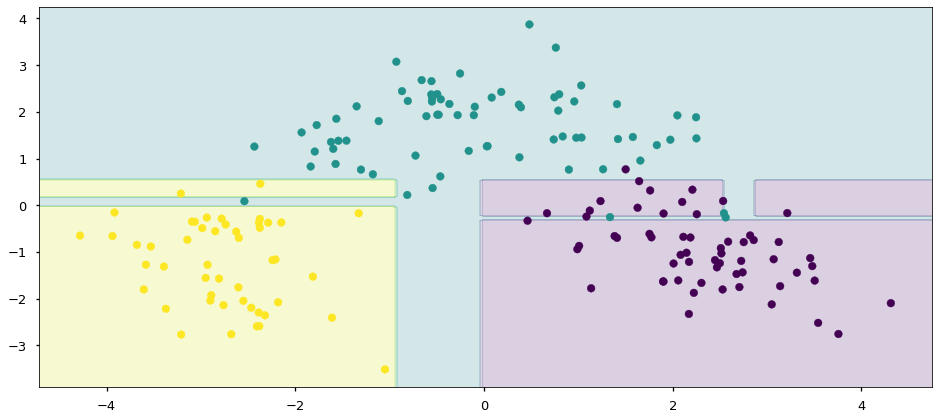

In [9]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.scatter(wine_pca[:, 0], wine_pca[:, 1], s=60, c=wine.target, cmap='viridis', zorder=2)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x = np.linspace(*xlim, num=200)
y = np.linspace(*ylim, num=200)
xx, yy = np.meshgrid(x, y)
z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax.contourf(xx, yy, z, alpha=0.2, cmap='viridis', zorder=1);

Good enough for such a simple classifier.
We can see overfitting but we can deal with that later.

Decision trees are simple and computationally cheap to use for multilabel classification,
also this is a model that can estimate class probabilities.
We can also extract the rules the tree has learned to explain what it is doing.
In other words, the decision tree is a white-box model.

That said, plain decision trees are very sensitive to outliers and variations in data.
One needs to ensure that data fed to a decision tree is scaled and has similar
support across all classes.
Trees tend to be biased to the most often found classes.

We should try to evaluate the generalization of our tree classifier.
We take a test set and compare that with a cross-validation score.

In [10]:
from sklearn.model_selection import cross_val_score, train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(wine_pca, wine.target, test_size=0.2)
model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
print('cross validation', cross_val_score(model, xtrain, ytrain))
print('test score', model.score(xtest, ytest))

cross validation [0.93103448 0.96551724 1.         0.96428571 0.92857143]
test score 0.9444444444444444


Yes, a decision tree has the bad habit of overfitting the data.
Moreover, with dimensionality reduced data we cannot take advantage of the white-box model.
This is because we cannot tell the meaning of the features after the reduction,
the new features are just a plane that contains the most variation.

Yet, training several trees and then bagging them together makes up for it.
Such ensembles are some of the most powerful classifiers,
these can draw very fluid decision boundaries between several classes at once.
When using several trees at once,
we lose the capacity of explaining what the model is doing (white-box),
yet for already (dimensionality) reduced data it does not matter.

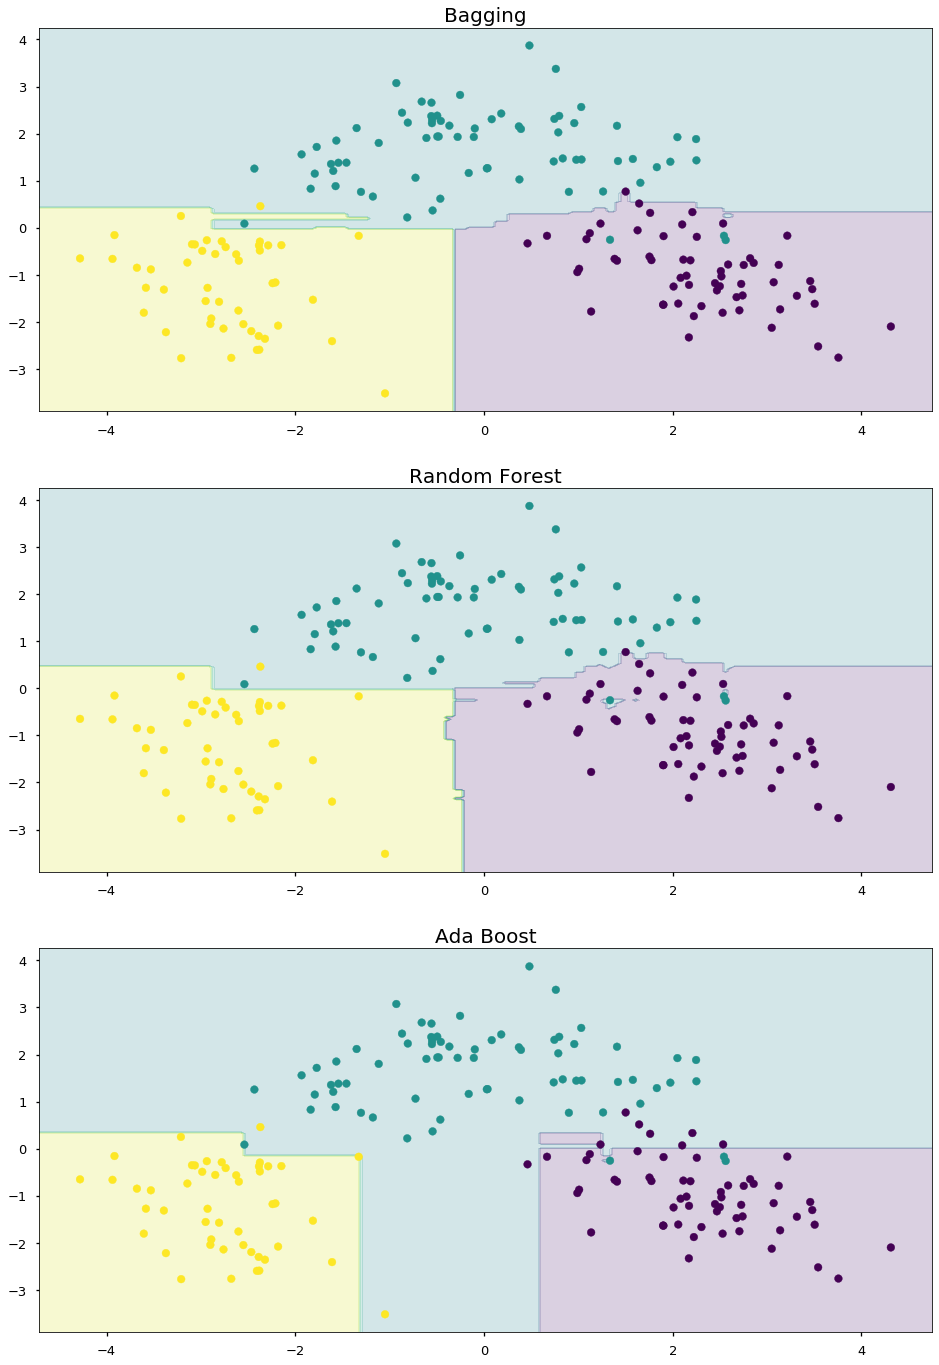

In [11]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
xtrain, xtest, ytrain, ytest = train_test_split(wine_pca, wine.target, test_size=0.2)
models = ['Bagging', 'Random Forest', 'Ada Boost']
model_dict = {
    'Bagging': BaggingClassifier(DecisionTreeClassifier(), n_estimators=30, max_samples=0.7),
    'Random Forest': RandomForestClassifier(n_estimators=30),
    'Ada Boost': AdaBoostClassifier(n_estimators=30)
}
fig, ax = plt.subplots(len(models), figsize=(16, 24))
for i, model_name in enumerate(models):
    model = model_dict[model_name]
    model.fit(xtrain, ytrain)
    ax[i].scatter(wine_pca[:, 0], wine_pca[:, 1], s=60, c=wine.target, cmap='viridis', zorder=2)
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()
    x = np.linspace(*xlim, num=200)
    y = np.linspace(*ylim, num=200)
    xx, yy = np.meshgrid(x, y)
    z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax[i].contourf(xx, yy, z, alpha=0.2, cmap='viridis', zorder=1)
    ax[i].set_title(model_name, fontsize=20)

### Bagging

Is the technique of simply training several trees on subsamples of the data.
Then taking the majority vote when predicting.

The sub-sampling is done *with replacement*,
meaning that the same sample can be selected several times into a bag.
In ensemble terms the sub-sampling with replacement is called **bootstrapped**.

A variant of the bagging algorithm is called *pasting*.
The difference with bagging is that in pasting the bags are taken not bootstrapped.
In other words, pasting is an algorithm that performs data sub-sampling
*without replacement* and then trains trees on these subsamples.
Pasting only really works on very big datasets.

### Random Forest

Apart from varying the number of samples each tree will see
we can also variate the features it will see.
A *random forest* trains several trees each on a sub-sample of the data
and a sub-sample of the features.
The sub-sampling can be performed *bootstrapped* (the default in `sklearn`) or not.

The higher randomization increases the variance of the model.
But the fact that we train several models and then take the majority vote
reduces the variance again.
The big advantage of random forests and bagging is the fact that
each ensemble model can be trained separately.
Which also means that it is easy to parallelize the algorithm across processes or even machines.

### Ada Boost

Boosting algorithms take a slightly different approach.
They train a very simple classifier with very high regularization,
e.g. a tree that can only split the data once (also called a tree stump).
Then the boosting algorithm finds the samples that the very simple classifier got wrong,
and updates the data set to put more weights to these samples.

Then the boosting algorithm trains a new very simple classifier (stump)
on the new, updated, dataset.
It is likely that the new classifier will classify the weighted samples correctly,
at the expense of the other samples.
On the next step the boosting algorithm again evaluates the just trained simple classifier,
and find the samples that this new classifier got wrong.
Now the algorithm puts more weight on the samples misclassified by the newest
classifier and trains yet another simple classifier on that set.
The algorithm repeats until the maximum number of simple classifiers (stumps) is reached.

The final answer from the algorithm is either a majority vote, or a weighted vote
(by misclassification error of each classifier or by predicted probabilities).

Ada Boost is the original algorithm, with several variant following it.
In general, boosting produces better results than bagging or pasting.
Yet, the fact that the ensemble cannot be parallelized makes the algorithm
less practical for use with very big datasets.

## Evaluation

The most common technique often used is the random forest.
This is thanks to the fact that it is easy to parallelize and produces
better results than plain bagging (or pasting) as the number of estimators increase.

Let's evaluate the performance of a random forest against the simple decision tree from before.

In [12]:
model = RandomForestClassifier(n_estimators=30)
model.fit(xtrain, ytrain)
print('cross validation', cross_val_score(model, xtrain, ytrain))
print('test score', model.score(xtest, ytest))

cross validation [0.93103448 0.89655172 0.96428571 0.96428571 0.89285714]
test score 0.9444444444444444


A tuned ensemble will perform better than a simple classifier, in most cases.

Decision trees are not the only estimators that can be used inside bagging or boosting algorithms.
Any simple classifier can benefit from ensemble methods.
Yet, the simplicity and possibility of tuning of trees make them the most common
classifiers used in big ensembles.

## Back to an old dataset - Iris

Let's check out the random forest in action on a slightly more complicated dataset.
The wine dataset above has very little overlap between classes but, if you remember,
the Iris dataset has a good separation of the *setosa* flower but a big
overlap between *versicolor* and *virginica*.
A random forest should be capable of drawing a decision boundary between the classes nevertheless.

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()
xtrain, xtest, ytrain, ytest = train_test_split(iris.data, iris.target, test_size=0.2)

And we should evaluate this properly.
We will tune the hyperparameters of the random forest through cross-validation,
therefore we cannot use the result of that as a generalization score.
We take out a test set to evaluate with.

In [14]:
from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()
param_dist = {
    'n_estimators': [10, 50, 100],
    'min_samples_leaf': [1, 2, 5]
}
grid = GridSearchCV(model, param_dist, cv=5)
grid.fit(xtrain, ytrain)
grid.best_score_, grid.best_estimator_

(0.9666666666666668,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=2, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

The cross-validation score for the tuned hyperparameters is very good.
But the test set should give us the proper generalization score.
Since this is a multilabel classification we can look at a classification report.

In [15]:
from sklearn.metrics import classification_report
yfit = grid.best_estimator_.predict(xtest)
print(classification_report(ytest, yfit, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         6
  versicolor       0.92      1.00      0.96        12
   virginica       1.00      0.92      0.96        12

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Unfortunately this is a tiny dataset,
therefore the support of the classes is very small.
Yet, we can see what we expected: *setosa* is perfectly separated,
and moreover, we have reasonable F1 score for the other classes.
Note: the F1 score for *versicolor* and *virginica* will depend on the random
split into the training and test set.

Since this is a tiny dataset,
let's throw a confusion matrix over all samples.
Just to see if it matches our visual evaluation of the set.

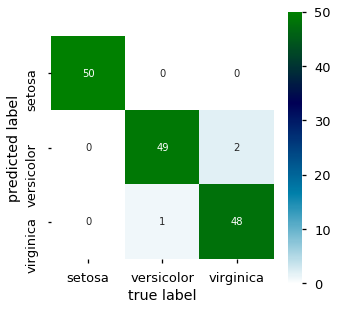

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
yfit_train = grid.best_estimator_.predict(xtrain)
m = confusion_matrix(np.hstack([ytrain, ytest]), np.hstack([yfit_train, yfit]))
fig = plt.figure(figsize=(5, 5))
ax = sns.heatmap(m.T, square=True, annot=True, fmt='d', cmap='ocean_r',
                 xticklabels=iris.target_names, yticklabels=iris.target_names)
ax.set(xlabel='true label', ylabel='predicted label');

And that's a pretty amazing result for a classifier.

## References

- [sklearn - Importance of Feature Scaling][1]

[1]: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html